## Setup

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from scipy import stats
# from collections import Counter
from pactools.grid_search import GridSearchCVProgressBar
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
# from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV,\
    cross_val_score, StratifiedKFold
# RandomizedSearchCV, 
from sklearn.metrics import plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report, plot_roc_curve, SCORERS
# from imblearn.under_sampling import TomekLinks
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from code.functions import *
# %matplotlib inline

# EDA

## Load Data

In [4]:
pd.set_option('display.max_columns',None)

In [11]:
df = pd.read_csv('data/cmc.data', names = ['age','edu','hus_edu','chil','rel','work',
                                        'hus_ocu','sol','media','cmc'])

## Feature Engineering

49 0.16295261509293898


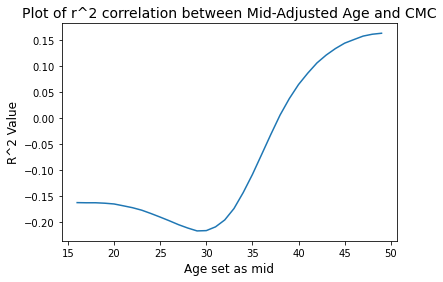

In [14]:
df_age = df.copy()
r_values = {}
ages = range(df_age.age.min(), df_age.age.max() + 1)
for age in ages:
    df_age['age_mid'] = np.abs(df_age['age'] - age)
    r_values[age] = df_age['age_mid'].corr(df_age.cmc)
fig, ax = plt.subplots()
ax.plot(*zip(*sorted(r_values.items())))
ax.set_title('Plot of r^2 correlation between Mid-Adjusted Age and CMC', fontdict = {'fontsize': 14})
ax.set_xlabel('Age set as mid', fontdict = {'fontsize': 12})
ax.set_ylabel('R^2 Value', fontdict = {'fontsize': 12})
print(max(r_values, key=r_values.get), max(r_values.values()))

0 0.08277224205909448


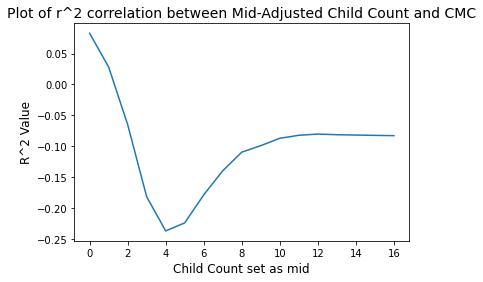

In [16]:
df_child = df.copy()
r_values = {}
childs = range(df_child.chil.min(), df_child.chil.max() + 1)
for child in childs:
    df_child['chil_mid'] = np.abs(df_child.chil - child)
    r_values[child] = df_child['chil_mid'].corr(df_child.cmc)
fig, ax = plt.subplots()
ax.plot(*zip(*sorted(r_values.items())))
ax.set_title('Plot of r^2 correlation between Mid-Adjusted Child Count and CMC', fontdict = {'fontsize': 14})
ax.set_xlabel('Child Count set as mid', fontdict = {'fontsize': 12})
ax.set_ylabel('R^2 Value', fontdict = {'fontsize': 12})
print(max(r_values, key=r_values.get), max(r_values.values()))

## Dummying, Scaling/Fit/Transform

In [7]:
X = df.copy()
y = X.pop('cmc')
to_dummy = ['edu', 'hus_edu', 'chil', 'hus_ocu', 'sol']
X_with_dums = pd.get_dummies(X, columns=to_dummy, drop_first=True)
# X_with_dums.shape
X_train, X_test, y_train, y_test = train_test_split(
    X_with_dums, y, test_size=.25,
    random_state=1)
# X_train.shape
rs = RobustScaler()
rs.fit(X_train)
X_train = rs.transform(X_train)
X_test = rs.transform(X_test)

# Modeling

## Logistic Regression w/ Children dummied

{'lr__multi_class': 'multinomial', 'lr__solver': 'lbfgs'}
Classifier  LogisticRegression
Num features:  10
Model score:  0.5230352303523035
Model F1 (micro):  0.5230352303523035
Model F1 (macro):  0.5075138852916631
Model F1 (weighted):  0.5178349169315745
Cross validation score:  [0.45945946 0.47297297 0.44594595 0.44594595 0.53424658]
Classification Report:
              precision    recall  f1-score   support

           1       0.55      0.65      0.60       149
           2       0.57      0.38      0.45        93
           3       0.46      0.48      0.47       127

    accuracy                           0.52       369
   macro avg       0.53      0.50      0.51       369
weighted avg       0.53      0.52      0.52       369

One-vs-One ROC AUC scores:
0.710310 (macro),
0.709975 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.711159 (macro),
0.707037 (weighted by prevalence)


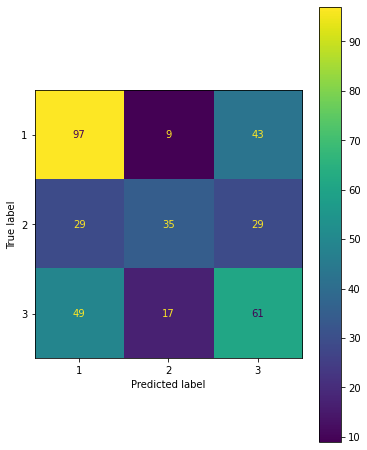

In [59]:
# set up pipeline
pipe_lr = Pipeline([('lr' , LogisticRegression(random_state=1, max_iter=200))])

params_grid_lr = {'lr__penalty' : ['l2','elasticnet'],
                  'lr__class_weight' : ['balanced'],
                  'lr__dual' : [True],
                  'lr__solver' : ['liblinear'],
                  'lr__C' : np.logspace(-4, 4, 20),
                  'lr__l1_ratio' : np.logspace(-4, 4, 20) # only needed for elasticnet
                 }

lr_clf = GridSearchCV(pipe_lr, param_grid = params_grid_lr, cv = 5, verbose=0, n_jobs=-1)

# fit on data
lr_clf.fit(X_train, y_train)
print(lr_clf.best_params_)
best_lr_clf = lr_clf.best_estimator_
model_stats(X_train.columns, best_lr_clf, 'LogisticRegression', X_test, y_test)

In [22]:
lr_clf_ = best_lr_clf.named_steps['lr']

In [23]:
coef_df = pd.DataFrame(lr_clf_.coef_, columns = X_with_dums.columns, index = [1,2,3])

In [24]:
coef_df

,age,rel,work,media,age_mid,edu_2,edu_3,edu_4,hus_edu_2,hus_edu_3,hus_edu_4,chil_1,chil_2,chil_3,chil_4,chil_5,chil_6,chil_7,chil_8,chil_9,chil_10,chil_11,chil_12,chil_13,chil_16,hus_ocu_2,hus_ocu_3,hus_ocu_4,sol_2,sol_3,sol_4
1,0.502491,0.395432,0.003208,0.552075,-0.502491,-0.139200,-0.616620,-1.301119,-0.101771,-0.165581,0.060539,-1.711366,-2.374520,-3.253646,-3.409400,-3.444145,-3.481303,-3.420587,-2.811764,-4.096732,-2.009558,-3.149783,0.224742,-3.484702,0.0,0.221694,0.065080,-0.505348,-0.474359,-0.735087,-0.859930
2,0.023951,-0.444111,-0.016516,-0.358237,-0.023951,0.712026,1.354083,1.833547,-1.369773,-1.433896,-1.257030,1.258516,1.281255,1.567683,1.951503,1.790165,2.057269,2.497766,1.701375,2.072760,1.568491,0.978597,-0.182817,2.193342,0.0,-0.623266,-0.440929,0.136517,0.296030,0.586999,0.681072
3,-0.545461,-0.034846,0.014685,-0.417811,0.545461,-0.216551,-0.102631,0.116797,1.282770,1.447292,1.162653,1.193398,1.870365,2.485830,2.386489,2.582598,2.469124,1.979021,1.922173,3.181314,-0.487136,2.896880,-0.332646,2.401356,0.0,0.311374,0.324846,0.560011,0.356215,0.435676,0.481536


In [25]:
coef_df.idxmax(axis = 1)

1     media
2    chil_7
3    chil_9
dtype: object

In [26]:
coef_df.idxmin(axis = 1)

1       chil_9
2    hus_edu_3
3          age
dtype: object

In [27]:
coef_df.loc[1]

age          0.502491
rel          0.395432
work         0.003208
media        0.552075
age_mid     -0.502491
edu_2       -0.139200
edu_3       -0.616620
edu_4       -1.301119
hus_edu_2   -0.101771
hus_edu_3   -0.165581
hus_edu_4    0.060539
chil_1      -1.711366
chil_2      -2.374520
chil_3      -3.253646
chil_4      -3.409400
chil_5      -3.444145
chil_6      -3.481303
chil_7      -3.420587
chil_8      -2.811764
chil_9      -4.096732
chil_10     -2.009558
chil_11     -3.149783
chil_12      0.224742
chil_13     -3.484702
chil_16      0.000000
hus_ocu_2    0.221694
hus_ocu_3    0.065080
hus_ocu_4   -0.505348
sol_2       -0.474359
sol_3       -0.735087
sol_4       -0.859930
Name: 1, dtype: float64

## Logistic Regression w/o Children dummied

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/wax/opt/anaconda3/lib/python3.8/site-packages

{'lr__C': 206.913808111479, 'lr__class_weight': 'balanced', 'lr__dual': True, 'lr__l1_ratio': 0.0001, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Classifier  LogisticRegression
Num features:  10
Model score:  0.5447154471544715
Model F1 (micro):  0.5447154471544715
Model F1 (macro):  0.5406335690165841
Model F1 (weighted):  0.5450905002305259


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/wax/opt/anaconda3/lib/python3.8/site-packages

Cross validation score:  [0.44594595 0.47297297 0.48648649 0.47297297 0.52054795]
Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.58      0.60       149
           2       0.49      0.58      0.53        93
           3       0.50      0.47      0.49       127

    accuracy                           0.54       369
   macro avg       0.54      0.55      0.54       369
weighted avg       0.55      0.54      0.55       369

One-vs-One ROC AUC scores:
0.713803 (macro),
0.712790 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713169 (macro),
0.709137 (weighted by prevalence)


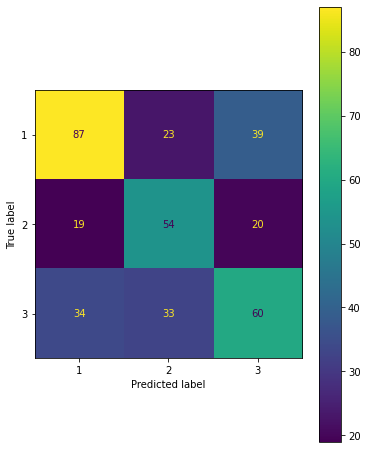

In [50]:
to_dummy = ['edu', 'hus_edu', 'hus_ocu', 'sol']
X_dums, X_train, X_test, y_train, y_test = dummy_transform_scale(X, y, to_dummy, rs = 729)
# set up pipeline
pipe_lr = Pipeline([('lr' , LogisticRegression(random_state=729, max_iter=200))])

params_grid_lr = {#'lr' : [LogisticRegression()],
                  'lr__penalty' : ['l2'],
                  'lr__class_weight' : ['balanced'],
                  'lr__dual' : [True],
                  'lr__solver' : ['liblinear'],
                  'lr__C' : np.logspace(-4, 4, 20),
                  'lr__l1_ratio' : np.logspace(-4, 4, 20)
                 }

lr_clf = GridSearchCV(pipe_lr, param_grid = params_grid_lr, cv = 5, verbose=0, n_jobs=-1)

# fit on data
lr_clf.fit(X_train, y_train)
print(lr_clf.best_params_)
best_lr_nochil_clf = lr_clf.best_estimator_
model_stats(X_train.columns, best_lr_nochil_clf, 'LogisticRegression', X_test, y_test)

In [29]:
best_lr_nochil_clf_ = best_lr_nochil_clf.named_steps['lr']

In [30]:
coef_df = pd.DataFrame(best_lr_nochil_clf_.coef_, columns = X_dums.columns, index = [1,2,3])

In [31]:
coef_df

,age,chil,rel,work,media,age_mid,edu_2,edu_3,edu_4,hus_edu_2,hus_edu_3,hus_edu_4,hus_ocu_2,hus_ocu_3,hus_ocu_4,sol_2,sol_3,sol_4
1,0.580052,-1.368333,0.302989,-0.241373,0.608861,-0.580052,-0.505996,-0.981393,-1.679886,-0.504899,-0.472952,-0.295195,0.335767,0.019804,-0.091242,-0.399563,-0.508515,-0.834612
2,-0.007965,0.578655,-0.354500,0.049860,-0.541171,0.007965,0.945664,1.581848,2.303498,-1.439521,-1.564085,-1.378741,-0.392269,-0.370106,-0.228198,0.178132,0.711501,0.864179
3,-0.618210,0.955515,-0.075525,0.225933,-0.337679,0.618210,0.098824,0.286165,0.400453,2.001003,1.974826,1.843995,0.012418,0.292210,0.432447,0.365269,0.275729,0.445004


In [ ]:
fig, ax = plt.subplots(figsize = [12,8])
coef_df.loc[1].plot()

## KNN using Pipeline

In [ ]:
X = df.copy()
y = X.pop('cmc')

In [ ]:
cat_columns = ['edu', 'hus_edu', 'chil', 'hus_ocu', 'sol']
# cat_columns = ['edu', 'hus_edu', 'hus_ocu', 'sol']
for col in cat_columns:
    X[col] = X[col].astype(object)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=729)

In [ ]:
# train set
X_train_nums = X_train.select_dtypes('int64')

rs = RobustScaler()
# ss = StandardScaler()

rs.fit(X_train_nums)
nums_df = pd.DataFrame(rs.transform(X_train_nums),
                      index=X_train_nums.index)

X_train_cat = X_train.select_dtypes('object')

ohe = OneHotEncoder(
    drop='first',
    sparse=False)

dums = ohe.fit_transform(X_train_cat)
dums_df = pd.DataFrame(dums,
                       columns=ohe.get_feature_names(),
                       index=X_train_cat.index)

In [ ]:
numerical_pipeline = Pipeline(steps=[
    ('rs', RobustScaler())
#     ('ss', StandardScaler())
])
                
categorical_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder( #drop='first',
                         sparse=False,
                         handle_unknown='ignore'))
])

trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, X_train_nums.columns),
    ('categorical', categorical_pipeline, X_train_cat.columns)
])

In [ ]:
model_pipe = Pipeline(steps=[
    ('trans', trans),
    ('knn', KNeighborsClassifier())
])

params_grid_knn = {'knn__n_neighbors': [3, 5, 7, 9],
             'knn__p': [1, 2, 3],
             'knn__weights' : ['uniform', 'distance'],
             'knn__metric' : ['euclidean', 'manhattan', 'minkowski']
            }

knn_clf = GridSearchCV(model_pipe, param_grid = params_grid_knn,
                       cv = 3, verbose=0, n_jobs=-1)

In [ ]:
knn_clf.fit(X_train, y_train)
print(knn_clf.best_params_)
best_knn_clf = knn_clf.best_estimator_
model_stats(X_train.columns, best_knn_clf, 'KNeighborsClassifier', y_test)

## SVM

In [ ]:
pipe_svm = Pipeline([
                     ('scl', RobustScaler()),
                     ('pca', PCA()),
                     ('svm', SVC(random_state=42, probability=True))])

params_grid_svm = {'svm__class_weight' : ['balanced', 'none'],
                   'svm__kernel' : ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                   'pca__n_components': [0, 2, 5, 10, 15, 20, 30, 45, 64],
                 }

svm_clf = GridSearchCV(pipe_svm, param_grid = params_grid_svm,
                       cv = 5, verbose=1, n_jobs=-1)
svm_clf.fit(X_train, y_train)
print(svm_clf.best_params_)
best_svm_clf = svm_clf.best_estimator_
model_stats(X_train.columns, best_svm_clf, 'SVM', X_test, y_test)

In [ ]:
SCORERS.keys()

array([0.1       , 0.11111111, 0.12222222, 0.13333333, 0.14444444,
       0.15555556, 0.16666667, 0.17777778, 0.18888889, 0.2       ])

# Predicting on new data

In [ ]:
df_1987_br = pd.read_stata('data/ID_1987_DHS_04012021_1716_161452/IDBR01DT/IDBR01FL.dta',
                )

                 names = ['age','edu','hus_edu','chil','rel','work',
                                        'hus_ocu','sol','media','cmc'])